In [1]:
# https://deeplearningcourses.com/c/unsupervised-deep-learning-in-python
# https://www.udemy.com/unsupervised-deep-learning-in-python
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle

In [2]:
def relu(x):
    return x * (x > 0)


def error_rate(p, t):
    return np.mean(p != t)


def getKaggleMNIST():
    # MNIST data:
    # column 0 is labels
    # column 1-785 is data, with values 0 .. 255
    # total size of CSV: (42000, 1, 28, 28)
    train = pd.read_csv('us_data/train.csv').as_matrix().astype(np.float32)
    train = shuffle(train)

    Xtrain = train[:-1000,1:] / 255
    Ytrain = train[:-1000,0].astype(np.int32)

    Xtest  = train[-1000:,1:] / 255
    Ytest  = train[-1000:,0].astype(np.int32)
    return Xtrain, Ytrain, Xtest, Ytest


def init_weights(shape):
    return np.random.randn(*shape) / np.sqrt(sum(shape))

In [3]:
class AutoEncoder(object):
    def __init__(self, D, M, an_id):
        self.M = M
        self.id = an_id
        self.build(D, M)

    def set_session(self, session):
        self.session = session

    def build(self, D, M):
        self.W = tf.Variable(tf.random_normal(shape=(D, M)))
        self.bh = tf.Variable(np.zeros(M).astype(np.float32))
        self.bo = tf.Variable(np.zeros(D).astype(np.float32))

        self.X_in = tf.placeholder(tf.float32, shape=(None, D))
        self.Z = self.forward_hidden(self.X_in) # for transform() later
        self.X_hat = self.forward_output(self.X_in)


        # using the naive formulation for cross-entropy
        # will have numerical stability issues if X_hat = 0 or 1
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.X_in,
                logits=logits,
            )
        )

        self.train_op = tf.train.AdamOptimizer(1e-1).minimize(self.cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-4, momentum=0.9).minimize(self.cost)

    def fit(self, X, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N // batch_sz

        costs = []
        print("training autoencoder: %s" % self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                _, c = self.session.run((self.train_op, self.cost), feed_dict={self.X_in: batch})
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)
                costs.append(c)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.Z, feed_dict={self.X_in: X})

    def predict(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.X_hat, feed_dict={self.X_in: X})

    def forward_hidden(self, X):
        Z = tf.nn.sigmoid(tf.matmul(X, self.W) + self.bh)
        return Z

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W)) + self.bo

    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

In [4]:
class DNN(object):
    def __init__(self, D, hidden_layer_sizes, K, UnsupervisedModel=AutoEncoder):
        self.hidden_layers = []
        count = 0
        input_size = D
        for output_size in hidden_layer_sizes:
            ae = UnsupervisedModel(input_size, output_size, count)
            self.hidden_layers.append(ae)
            count += 1
            input_size = output_size
        self.build_final_layer(D, hidden_layer_sizes[-1], K)

    def set_session(self, session):
        self.session = session
        for layer in self.hidden_layers:
            layer.set_session(session)

    def build_final_layer(self, D, M, K):
        # initialize logistic regression layer
        self.W = tf.Variable(tf.random_normal(shape=(M, K)))
        self.b = tf.Variable(np.zeros(K).astype(np.float32))

        self.X = tf.placeholder(tf.float32, shape=(None, D))
        labels = tf.placeholder(tf.int32, shape=(None,))
        self.Y = labels
        logits = self.forward(self.X)

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits,
                labels=labels
            )
        )
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)
        self.prediction = tf.argmax(logits, 1)

    def fit(self, X, Y, Xtest, Ytest, pretrain=True, epochs=1, batch_sz=100):
        N = len(X)

        # greedy layer-wise training of autoencoders
        pretrain_epochs = 1
        if not pretrain:
            pretrain_epochs = 0

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)

            # create current_input for the next layer
            current_input = ae.transform(current_input)

        n_batches = N // batch_sz
        costs = []
        print("supervised training...")
        for i in range(epochs):
            print("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                self.session.run(
                    self.train_op,
                    feed_dict={self.X: Xbatch, self.Y: Ybatch}
                )
                c, p = self.session.run(
                    (self.cost, self.prediction),
                    feed_dict={self.X: Xtest, self.Y: Ytest
                })
                error = error_rate(p, Ytest)
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c, "error:", error)
                costs.append(c)
        plt.plot(costs)
        plt.show()

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        # logistic layer
        logits = tf.matmul(current_input, self.W) + self.b
        return logits

In [5]:
def test_pretraining_dnn():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    # dnn = DNN([1000, 750, 500])
    # dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=3)
    # vs
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    _, D = Xtrain.shape
    K = len(set(Ytrain))
    dnn = DNN(D, [1000, 750, 500], K)
    init_op = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init_op)
        dnn.set_session(session)
        dnn.fit(Xtrain, Ytrain, Xtest, Ytest, pretrain=True, epochs=10)


def test_single_autoencoder():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)

    _, D = Xtrain.shape
    autoencoder = AutoEncoder(D, 300, 0)
    init_op = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init_op)
        autoencoder.set_session(session)
        autoencoder.fit(Xtrain, show_fig=True)

        done = False
        while not done:
            i = np.random.choice(len(Xtest))
            x = Xtest[i]
            y = autoencoder.predict([x])
            plt.subplot(1,2,1)
            plt.imshow(x.reshape(28,28), cmap='gray')
            plt.title('Original')

            plt.subplot(1,2,2)
            plt.imshow(y.reshape(28,28), cmap='gray')
            plt.title('Reconstructed')

            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

training autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 cost: 4.63662
j / n_batches: 10 / 410 cost: 0.299568
j / n_batches: 20 / 410 cost: 0.26056
j / n_batches: 30 / 410 cost: 0.212415
j / n_batches: 40 / 410 cost: 0.195081
j / n_batches: 50 / 410 cost: 0.193531
j / n_batches: 60 / 410 cost: 0.185905
j / n_batches: 70 / 410 cost: 0.180272
j / n_batches: 80 / 410 cost: 0.175719
j / n_batches: 90 / 410 cost: 0.161573
j / n_batches: 100 / 410 cost: 0.171097
j / n_batches: 110 / 410 cost: 0.160754
j / n_batches: 120 / 410 cost: 0.146988
j / n_batches: 130 / 410 cost: 0.148759
j / n_batches: 140 / 410 cost: 0.152912
j / n_batches: 150 / 410 cost: 0.147494
j / n_batches: 160 / 410 cost: 0.143705
j / n_batches: 170 / 410 cost: 0.152162
j / n_batches: 180 / 410 cost: 0.137636
j / n_batches: 190 / 410 cost: 0.135461
j / n_batches: 200 / 410 cost: 0.142186
j / n_batches: 210 / 410 cost: 0.139235
j / n_batches: 220 / 410 cost: 0.13859
j / n_batches: 230 / 410 cost: 0.13814
j / n_batches: 240 / 4

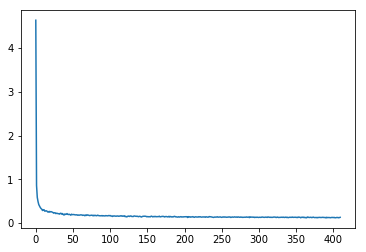

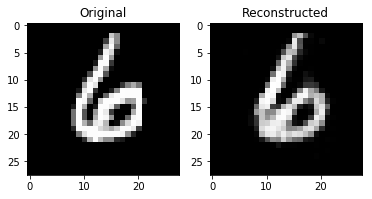

Generate another?n


In [6]:
test_single_autoencoder()

training autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 cost: 7.59857
j / n_batches: 10 / 410 cost: 0.311432
j / n_batches: 20 / 410 cost: 0.248479
j / n_batches: 30 / 410 cost: 0.207722
j / n_batches: 40 / 410 cost: 0.201361
j / n_batches: 50 / 410 cost: 0.174455
j / n_batches: 60 / 410 cost: 0.168023
j / n_batches: 70 / 410 cost: 0.168259
j / n_batches: 80 / 410 cost: 0.156604
j / n_batches: 90 / 410 cost: 0.1557
j / n_batches: 100 / 410 cost: 0.15867
j / n_batches: 110 / 410 cost: 0.14784
j / n_batches: 120 / 410 cost: 0.144455
j / n_batches: 130 / 410 cost: 0.137525
j / n_batches: 140 / 410 cost: 0.136473
j / n_batches: 150 / 410 cost: 0.132422
j / n_batches: 160 / 410 cost: 0.133675
j / n_batches: 170 / 410 cost: 0.138066
j / n_batches: 180 / 410 cost: 0.127025
j / n_batches: 190 / 410 cost: 0.137241
j / n_batches: 200 / 410 cost: 0.14129
j / n_batches: 210 / 410 cost: 0.127146
j / n_batches: 220 / 410 cost: 0.128921
j / n_batches: 230 / 410 cost: 0.127059
j / n_batches: 240 / 410

j / n_batches: 200 / 410 cost: 0.232746 error: 0.063
j / n_batches: 210 / 410 cost: 0.210316 error: 0.052
j / n_batches: 220 / 410 cost: 0.215477 error: 0.055
j / n_batches: 230 / 410 cost: 0.216285 error: 0.062
j / n_batches: 240 / 410 cost: 0.260687 error: 0.063
j / n_batches: 250 / 410 cost: 0.256397 error: 0.067
j / n_batches: 260 / 410 cost: 0.220812 error: 0.055
j / n_batches: 270 / 410 cost: 0.24973 error: 0.07
j / n_batches: 280 / 410 cost: 0.231393 error: 0.065
j / n_batches: 290 / 410 cost: 0.239253 error: 0.074
j / n_batches: 300 / 410 cost: 0.246214 error: 0.067
j / n_batches: 310 / 410 cost: 0.229242 error: 0.064
j / n_batches: 320 / 410 cost: 0.246813 error: 0.061
j / n_batches: 330 / 410 cost: 0.249076 error: 0.06
j / n_batches: 340 / 410 cost: 0.256679 error: 0.067
j / n_batches: 350 / 410 cost: 0.226851 error: 0.053
j / n_batches: 360 / 410 cost: 0.243284 error: 0.06
j / n_batches: 370 / 410 cost: 0.239365 error: 0.064
j / n_batches: 380 / 410 cost: 0.240214 error: 0.0

j / n_batches: 150 / 410 cost: 0.181586 error: 0.048
j / n_batches: 160 / 410 cost: 0.206725 error: 0.045
j / n_batches: 170 / 410 cost: 0.214295 error: 0.044
j / n_batches: 180 / 410 cost: 0.225014 error: 0.043
j / n_batches: 190 / 410 cost: 0.202334 error: 0.044
j / n_batches: 200 / 410 cost: 0.237702 error: 0.054
j / n_batches: 210 / 410 cost: 0.229387 error: 0.051
j / n_batches: 220 / 410 cost: 0.224317 error: 0.046
j / n_batches: 230 / 410 cost: 0.221001 error: 0.049
j / n_batches: 240 / 410 cost: 0.198839 error: 0.05
j / n_batches: 250 / 410 cost: 0.180838 error: 0.046
j / n_batches: 260 / 410 cost: 0.219152 error: 0.048
j / n_batches: 270 / 410 cost: 0.188732 error: 0.047
j / n_batches: 280 / 410 cost: 0.181327 error: 0.049
j / n_batches: 290 / 410 cost: 0.194973 error: 0.044
j / n_batches: 300 / 410 cost: 0.204151 error: 0.044
j / n_batches: 310 / 410 cost: 0.217494 error: 0.046
j / n_batches: 320 / 410 cost: 0.213889 error: 0.044
j / n_batches: 330 / 410 cost: 0.226953 error: 

j / n_batches: 90 / 410 cost: 0.180746 error: 0.048
j / n_batches: 100 / 410 cost: 0.190355 error: 0.048
j / n_batches: 110 / 410 cost: 0.197677 error: 0.049
j / n_batches: 120 / 410 cost: 0.199401 error: 0.05
j / n_batches: 130 / 410 cost: 0.19634 error: 0.048
j / n_batches: 140 / 410 cost: 0.192918 error: 0.048
j / n_batches: 150 / 410 cost: 0.191724 error: 0.044
j / n_batches: 160 / 410 cost: 0.20212 error: 0.048
j / n_batches: 170 / 410 cost: 0.209272 error: 0.045
j / n_batches: 180 / 410 cost: 0.209246 error: 0.052
j / n_batches: 190 / 410 cost: 0.194714 error: 0.055
j / n_batches: 200 / 410 cost: 0.203882 error: 0.05
j / n_batches: 210 / 410 cost: 0.219264 error: 0.051
j / n_batches: 220 / 410 cost: 0.214962 error: 0.053
j / n_batches: 230 / 410 cost: 0.206806 error: 0.045
j / n_batches: 240 / 410 cost: 0.190346 error: 0.051
j / n_batches: 250 / 410 cost: 0.17625 error: 0.042
j / n_batches: 260 / 410 cost: 0.193587 error: 0.044
j / n_batches: 270 / 410 cost: 0.211331 error: 0.051

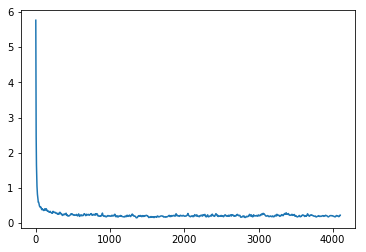

In [7]:
test_pretraining_dnn()